# Experiment 3: Partial Supervision Training

Comparative study of semantic segmentation under partial supervision constraints.

**Experimental Design:**

- Label fractions: 10%, 20% (sparse supervision scenarios)
- Architectures: UNet, UNet++ (architecture comparison)
- Total experiments: 4 (2 fractions × 2 architectures)


In [ ]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from src import *
import sys
from pathlib import Path
sys.path.append('..')


set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

torch.backends.cudnn.benchmark = True

## Configuration


In [ ]:
DATA_ROOT = Path("../data")
RESULTS_DIR = Path("../runs")
RESULTS_DIR.mkdir(exist_ok=True)

CONFIG = {
    'num_classes': 5,
    'ignore_index': -1,
    'batch_size': 8,
    'num_workers': 4,
    'epochs': 10,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'seed': 42,
    'use_amp': True,
    'resize_to': 384
}

LABEL_FRACTIONS = [0.1, 0.2]
ARCHITECTURES = ['unet', 'unetplusplus']

print(json.dumps(CONFIG, indent=2))
print(f"\nExperiments: {len(LABEL_FRACTIONS) * len(ARCHITECTURES)}")
print(f"  Label fractions: {[f'{int(f*100)}%' for f in LABEL_FRACTIONS]}")
print(f"  Architectures: {ARCHITECTURES}")

Configuration:
{
  "num_classes": 5,
  "ignore_index": -1,
  "batch_size": 16,
  "num_workers": 4,
  "epochs": 5,
  "learning_rate": 0.0001,
  "weight_decay": 0.0001,
  "architecture": "unet",
  "seed": 42,
  "use_amp": true,
  "resize_to": 384
}

Label fractions: [0.05, 0.1, 0.2]
Total experiments: 3
DEBUG mode: False

⚡ Performance settings:
  - Input size: 384x384 (resized from 512x512)
  - Batch size: 16
  - Mixed Precision (AMP): True
  - Expected epoch time: ~2-3 minutes (vs 7-10 min at 512x512)
  - Total training time per experiment: ~12 min


## Class Weight Calculation


In [ ]:
from collections import Counter

temp_val_dataset = LandCoverDataset(
    data_dir=DATA_ROOT,
    split='val',
    transform=get_val_transform(resize_to=CONFIG['resize_to']),
    labeled_fraction=1.0,
    seed=CONFIG['seed'],
    use_split_file=True
)

class_counts = Counter()
for idx in range(min(100, len(temp_val_dataset))):
    _, mask = temp_val_dataset[idx]
    unique, counts = np.unique(mask.numpy(), return_counts=True)
    for cls, count in zip(unique, counts):
        if cls != -1:
            class_counts[cls] += count

total_pixels = sum(class_counts.values())
class_weights = torch.tensor([
    total_pixels / (CONFIG['num_classes'] * class_counts.get(i, 1))
    for i in range(CONFIG['num_classes'])
], dtype=torch.float32)
class_weights = class_weights / class_weights.mean()

print(f"Class weights: {class_weights.tolist()}")

Calculating class weights from validation set...
✓ Loaded 1602 patches from val.txt

Class distribution (from 100 validation images at 384x384):
------------------------------------------------------------
Building     (class 0):  5,522,086 pixels (37.45%) → weight: 0.5341
Woodland     (class 1):     76,956 pixels ( 0.52%) → weight: 38.3222
Water        (class 2):  7,401,476 pixels (50.19%) → weight: 0.3985
Road         (class 3):  1,573,201 pixels (10.67%) → weight: 1.8746
Background   (class 4):    171,881 pixels ( 1.17%) → weight: 17.1579

Normalized class weights: [0.045812733471393585, 3.2873570919036865, 0.034179918467998505, 0.1608070731163025, 1.4718430042266846]
These weights will be applied to the loss function to handle class imbalance.
------------------------------------------------------------



EXPERIMENT: label_frac=0.05

✓ Loaded 7470 patches from train.txt
✓ Loaded 1602 patches from val.txt
Train dataset: 7470 patches
Val dataset: 1602 patches
Created local UNet implementation


c:\personal\PyTorch-Implementation-of-UNet-for-Land-Cover-Segmentation-with-Partial-CE-Loss\notebooks\..\src\train.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if self.use_amp else None



Starting training for label_fraction=0.05
  Input size: 384x384
  Batch size: 16
  AMP enabled: True

Starting training for 5 epochs
Mode: partial_ce
Device: cuda
Mixed Precision (AMP): True
Train batches: 467
Val batches: 101
------------------------------------------------------------


Epoch 1 [Train]:   0%|          | 0/467 [00:00<?, ?it/s]c:\personal\PyTorch-Implementation-of-UNet-for-Land-Cover-Segmentation-with-Partial-CE-Loss\notebooks\..\src\train.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|          | 0/101 [00:00<?, ?it/s]c:\personal\PyTorch-Implementation-of-UNet-for-Land-Cover-Segmentation-with-Partial-CE-Loss\notebooks\..\src\train.py:126: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 101/101 [00:40<00:00,  2.51it/s, loss=0.1680]



Epoch 1/5
  Train Loss: 0.0920
  Val Loss: 0.0691
  Val mIoU: 0.3513
  Val Acc: 0.7446
Checkpoint saved to ..\runs\frac5_partial_ce\best_model.pth
  ✓ New best mIoU: 0.3513


Validation: 100%|██████████| 101/101 [00:39<00:00,  2.59it/s, loss=0.0926]



Epoch 2/5
  Train Loss: 0.0669
  Val Loss: 0.0522
  Val mIoU: 0.3716
  Val Acc: 0.7787
Checkpoint saved to ..\runs\frac5_partial_ce\best_model.pth
  ✓ New best mIoU: 0.3716


Validation: 100%|██████████| 101/101 [00:39<00:00,  2.59it/s, loss=0.1032]



Epoch 3/5
  Train Loss: 0.0567
  Val Loss: 0.0437
  Val mIoU: 0.4129
  Val Acc: 0.8161
Checkpoint saved to ..\runs\frac5_partial_ce\best_model.pth
  ✓ New best mIoU: 0.4129


Validation: 100%|██████████| 101/101 [00:38<00:00,  2.60it/s, loss=0.1275]



Epoch 4/5
  Train Loss: 0.0522
  Val Loss: 0.0529
  Val mIoU: 0.3469
  Val Acc: 0.7517


Validation: 100%|██████████| 101/101 [00:39<00:00,  2.59it/s, loss=0.0765]



Epoch 5/5
  Train Loss: 0.0483
  Val Loss: 0.0383
  Val mIoU: 0.4268
  Val Acc: 0.8348
Checkpoint saved to ..\runs\frac5_partial_ce\best_model.pth
  ✓ New best mIoU: 0.4268

Training completed!
Best validation mIoU: 0.4268

✓ Experiment complete: ..\runs\frac5_partial_ce

EXPERIMENT: label_frac=0.1

✓ Loaded 7470 patches from train.txt
✓ Loaded 1602 patches from val.txt
Train dataset: 7470 patches
Val dataset: 1602 patches
Created local UNet implementation

Starting training for label_fraction=0.1
  Input size: 384x384
  Batch size: 16
  AMP enabled: True

Starting training for 5 epochs
Mode: partial_ce
Device: cuda
Mixed Precision (AMP): True
Train batches: 467
Val batches: 101
------------------------------------------------------------


Validation: 100%|██████████| 101/101 [00:39<00:00,  2.59it/s, loss=0.1302]



Epoch 1/5
  Train Loss: 0.0936
  Val Loss: 0.0712
  Val mIoU: 0.3259
  Val Acc: 0.7102
Checkpoint saved to ..\runs\frac10_partial_ce\best_model.pth
  ✓ New best mIoU: 0.3259


Validation: 100%|██████████| 101/101 [00:38<00:00,  2.60it/s, loss=0.1099]



Epoch 2/5
  Train Loss: 0.0679
  Val Loss: 0.0627
  Val mIoU: 0.3381
  Val Acc: 0.7465
Checkpoint saved to ..\runs\frac10_partial_ce\best_model.pth
  ✓ New best mIoU: 0.3381


Validation: 100%|██████████| 101/101 [00:39<00:00,  2.59it/s, loss=0.0899]



Epoch 3/5
  Train Loss: 0.0566
  Val Loss: 0.0473
  Val mIoU: 0.3784
  Val Acc: 0.7675
Checkpoint saved to ..\runs\frac10_partial_ce\best_model.pth
  ✓ New best mIoU: 0.3784


Validation: 100%|██████████| 101/101 [00:38<00:00,  2.59it/s, loss=0.1193]



Epoch 4/5
  Train Loss: 0.0519
  Val Loss: 0.0504
  Val mIoU: 0.3874
  Val Acc: 0.8121
Checkpoint saved to ..\runs\frac10_partial_ce\best_model.pth
  ✓ New best mIoU: 0.3874


Validation: 100%|██████████| 101/101 [00:38<00:00,  2.60it/s, loss=0.1170]



Epoch 5/5
  Train Loss: 0.0486
  Val Loss: 0.0396
  Val mIoU: 0.4482
  Val Acc: 0.8521
Checkpoint saved to ..\runs\frac10_partial_ce\best_model.pth
  ✓ New best mIoU: 0.4482

Training completed!
Best validation mIoU: 0.4482

✓ Experiment complete: ..\runs\frac10_partial_ce

EXPERIMENT: label_frac=0.2

✓ Loaded 7470 patches from train.txt
✓ Loaded 1602 patches from val.txt
Train dataset: 7470 patches
Val dataset: 1602 patches
Created local UNet implementation

Starting training for label_fraction=0.2
  Input size: 384x384
  Batch size: 16
  AMP enabled: True

Starting training for 5 epochs
Mode: partial_ce
Device: cuda
Mixed Precision (AMP): True
Train batches: 467
Val batches: 101
------------------------------------------------------------


Validation: 100%|██████████| 101/101 [00:38<00:00,  2.59it/s, loss=0.1329]



Epoch 1/5
  Train Loss: 0.0919
  Val Loss: 0.0737
  Val mIoU: 0.3453
  Val Acc: 0.7276
Checkpoint saved to ..\runs\frac20_partial_ce\best_model.pth
  ✓ New best mIoU: 0.3453


Validation: 100%|██████████| 101/101 [00:38<00:00,  2.59it/s, loss=0.0858]



Epoch 2/5
  Train Loss: 0.0682
  Val Loss: 0.0581
  Val mIoU: 0.2972
  Val Acc: 0.6789


Validation: 100%|██████████| 101/101 [00:38<00:00,  2.59it/s, loss=0.0840]



Epoch 3/5
  Train Loss: 0.0568
  Val Loss: 0.0449
  Val mIoU: 0.3923
  Val Acc: 0.8047
Checkpoint saved to ..\runs\frac20_partial_ce\best_model.pth
  ✓ New best mIoU: 0.3923


Validation: 100%|██████████| 101/101 [00:39<00:00,  2.58it/s, loss=0.0863]



Epoch 4/5
  Train Loss: 0.0517
  Val Loss: 0.0448
  Val mIoU: 0.4019
  Val Acc: 0.8112
Checkpoint saved to ..\runs\frac20_partial_ce\best_model.pth
  ✓ New best mIoU: 0.4019


Validation: 100%|██████████| 101/101 [00:38<00:00,  2.59it/s, loss=0.1433]



Epoch 5/5
  Train Loss: 0.0474
  Val Loss: 0.0502
  Val mIoU: 0.3644
  Val Acc: 0.7548

Training completed!
Best validation mIoU: 0.4019

✓ Experiment complete: ..\runs\frac20_partial_ce

ALL EXPERIMENTS COMPLETED


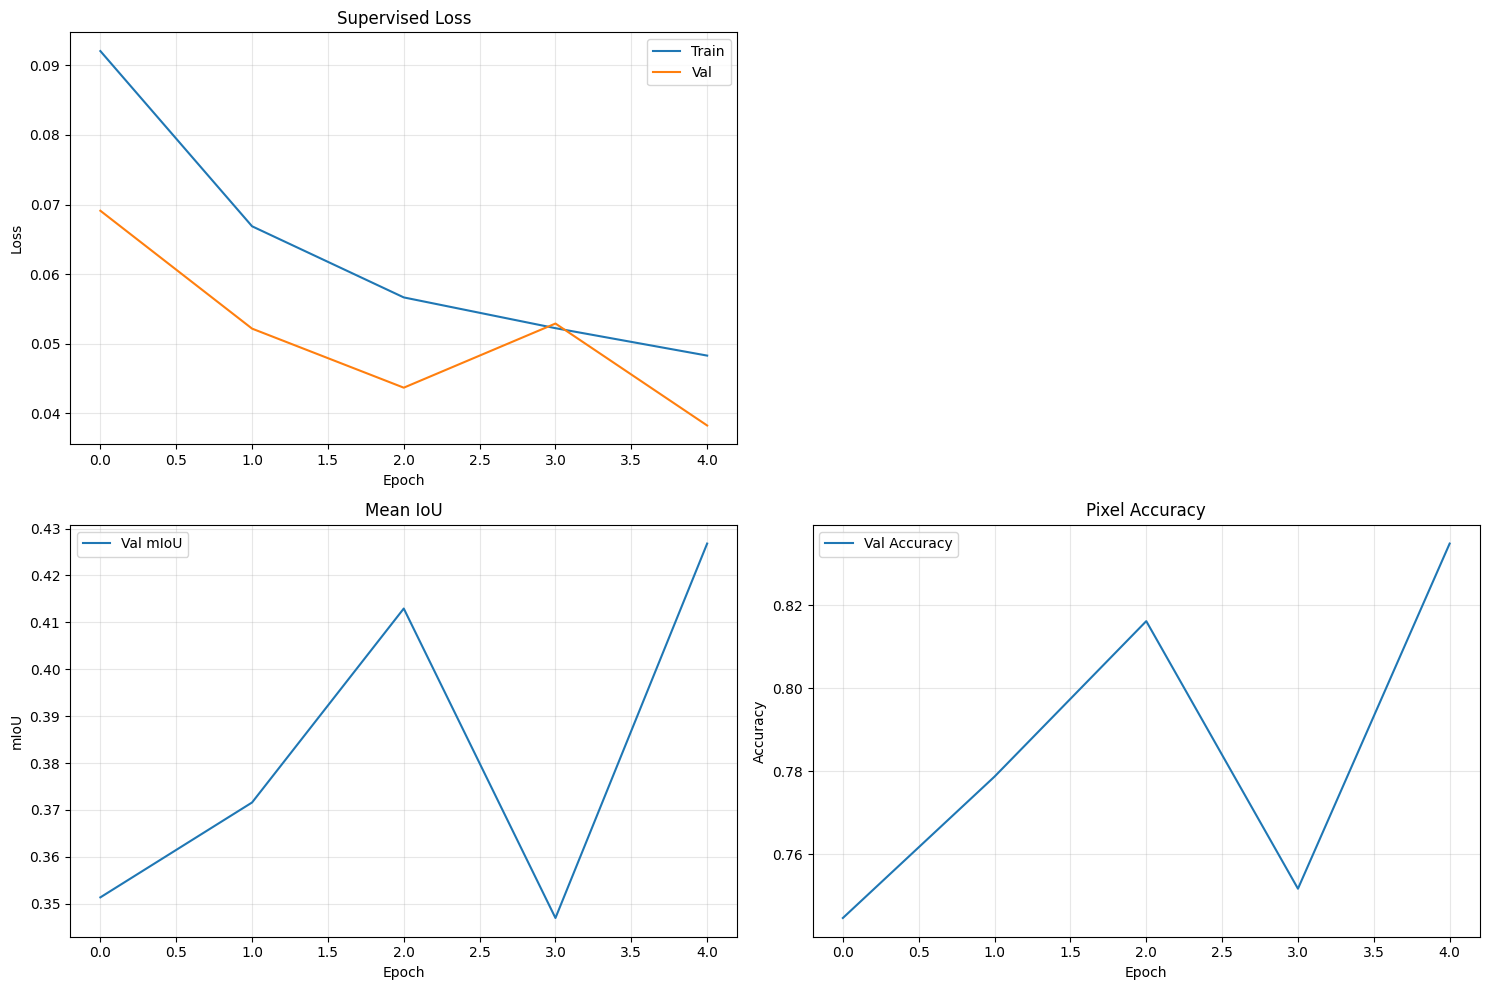

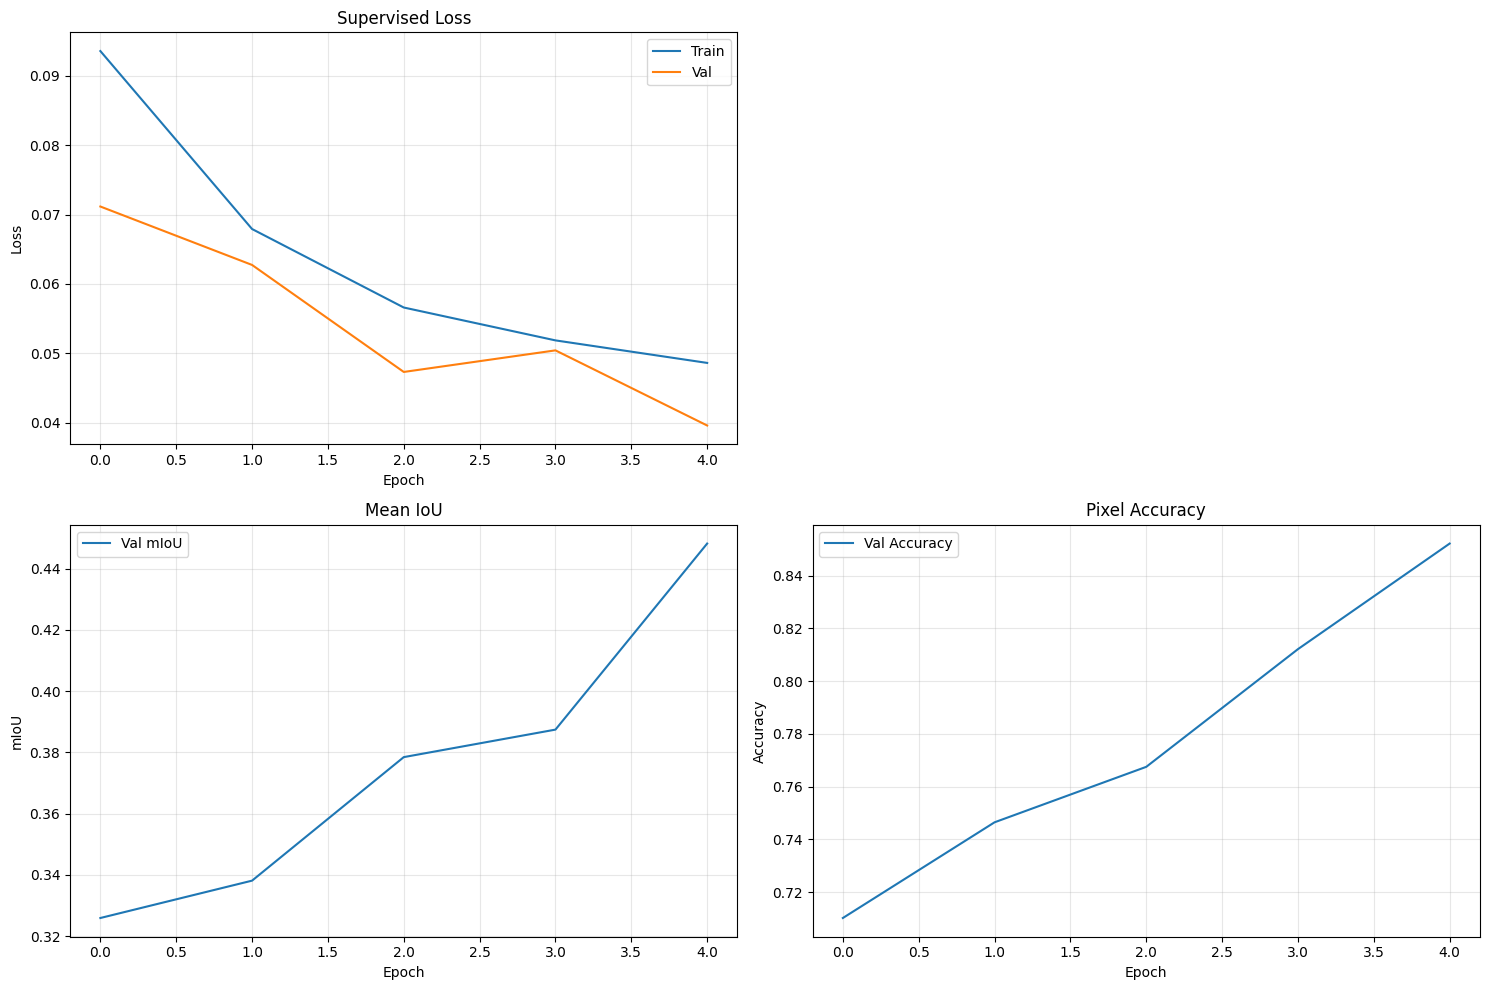

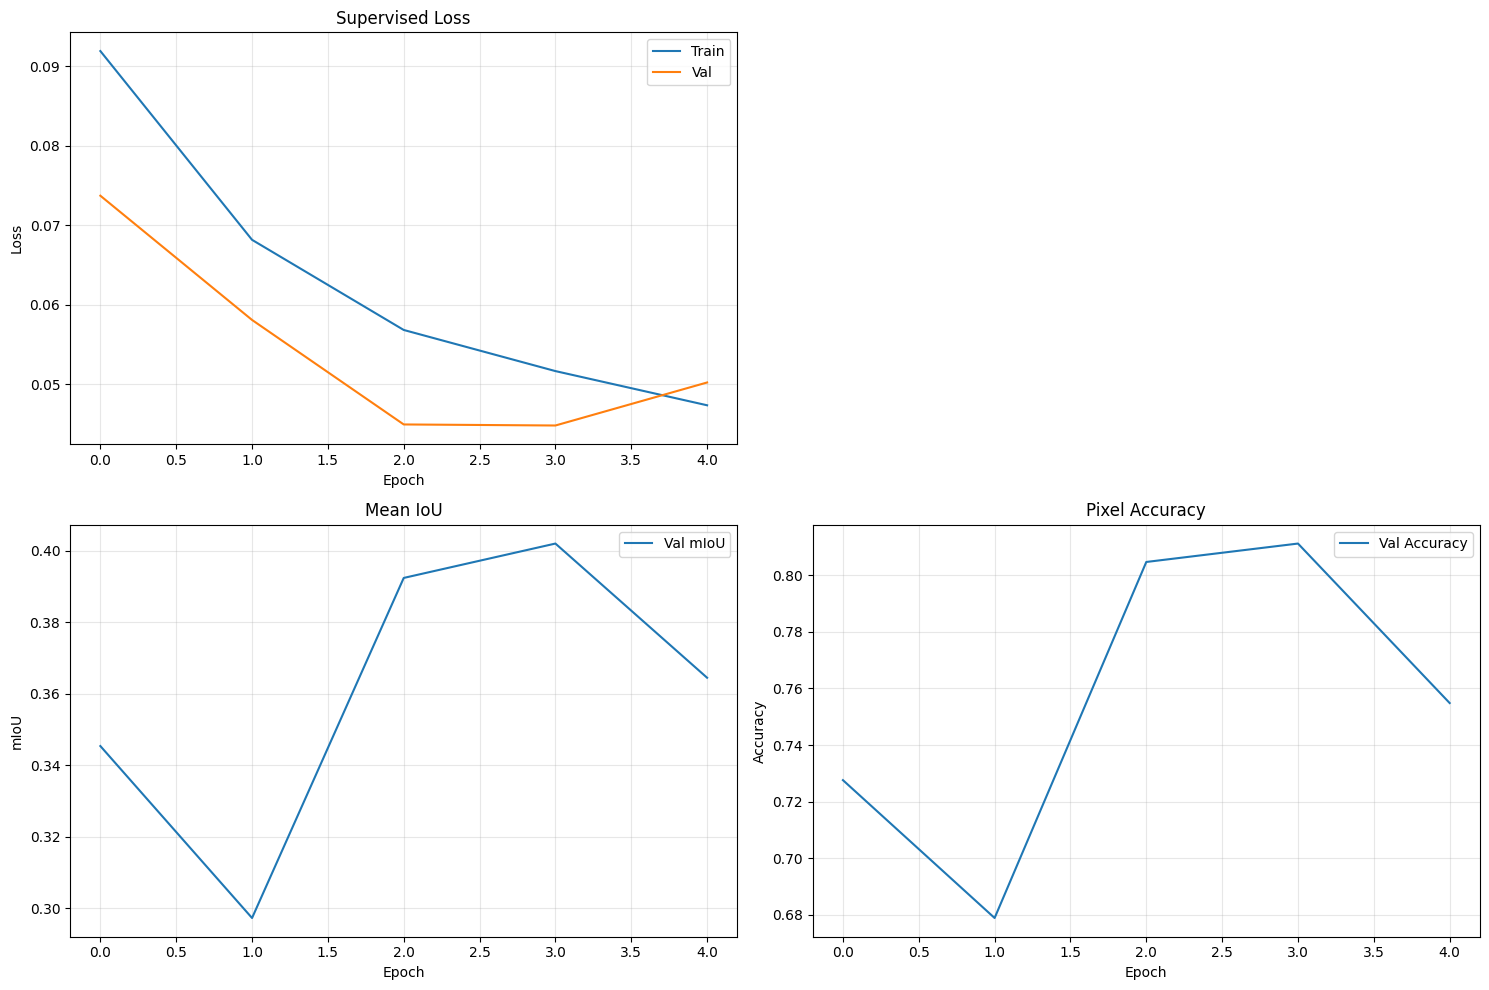

In [ ]:
all_results = []

for arch in ARCHITECTURES:
    for label_frac in LABEL_FRACTIONS:
        print(f"\n{'='*70}")
        print(
            f"Architecture: {arch.upper()} | Label fraction: {int(label_frac*100)}%")
        print(f"{'='*70}")

        train_dataset = LandCoverDataset(
            data_dir=DATA_ROOT,
            split='train',
            transform=get_train_transform(resize_to=CONFIG['resize_to']),
            labeled_fraction=label_frac,
            seed=CONFIG['seed'],
            use_split_file=True
        )

        val_dataset = LandCoverDataset(
            data_dir=DATA_ROOT,
            split='val',
            transform=get_val_transform(resize_to=CONFIG['resize_to']),
            labeled_fraction=1.0,
            seed=CONFIG['seed'],
            use_split_file=True
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=True,
            num_workers=CONFIG['num_workers'],
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=False,
            num_workers=CONFIG['num_workers'],
            pin_memory=True
        )

        model = get_unet(
            model_type=arch,
            classes=CONFIG['num_classes'],
            in_channels=3
        )

        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=CONFIG['learning_rate'],
            weight_decay=CONFIG['weight_decay']
        )

        criterion = PartialCrossEntropyLoss(
            ignore_index=CONFIG['ignore_index'],
            weight=class_weights.to(device)
        )

        exp_dir = RESULTS_DIR / f"{arch}_frac{int(label_frac*100)}"
        exp_dir.mkdir(exist_ok=True, parents=True)

        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            mode='partial_ce',
            num_classes=CONFIG['num_classes'],
            ignore_index=CONFIG['ignore_index'],
            save_dir=str(exp_dir),
            use_amp=CONFIG['use_amp']
        )

        history = trainer.fit(num_epochs=CONFIG['epochs'], save_best=True)

        all_results.append({
            'architecture': arch,
            'label_fraction': label_frac,
            'history': history,
            'final_val_miou': history['val_miou'][-1],
            'best_val_miou': max(history['val_miou']),
            'final_val_acc': history['val_acc'][-1],
            'exp_dir': str(exp_dir)
        })

        plot_training_history(
            history, save_path=exp_dir / 'training_history.png')

print("\n✓ All experiments completed")

## Results


In [9]:
# Create summary DataFrame
summary_data = []
for r in all_results:
    summary_data.append({
        'Label Fraction': f"{int(r['label_fraction']*100)}%",
        'Final mIoU': f"{r['final_val_miou']:.4f}",
        'Best mIoU': f"{r['best_val_miou']:.4f}",
        'Final Accuracy': f"{r['final_val_acc']:.4f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(df_summary.to_string(index=False))
print("="*60)


RESULTS SUMMARY
Label Fraction Final mIoU Best mIoU Final Accuracy
            5%     0.4268    0.4268         0.8348
           10%     0.4482    0.4482         0.8521
           20%     0.3644    0.4019         0.7548


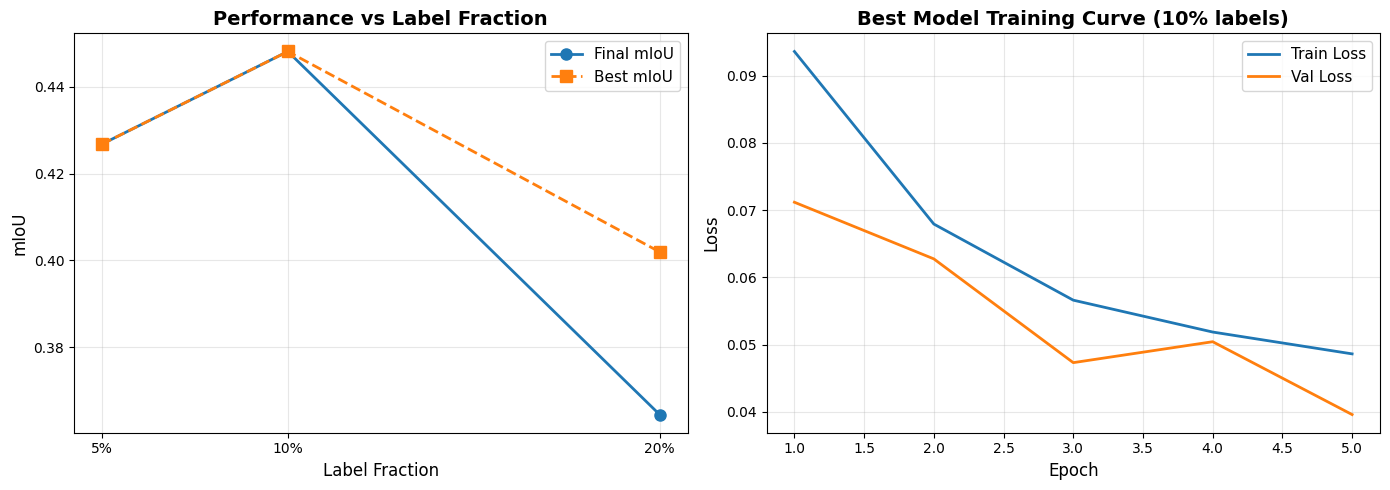

Comparison plots saved to: ..\runs\comparison_plots.png


In [10]:
# Extract data for plotting
label_fracs = [r['label_fraction'] for r in all_results]
final_mious = [r['final_val_miou'] for r in all_results]
best_mious = [r['best_val_miou'] for r in all_results]

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: mIoU vs Label Fraction
axes[0].plot(label_fracs, final_mious, 'o-',
             label='Final mIoU', linewidth=2, markersize=8)
axes[0].plot(label_fracs, best_mious, 's--',
             label='Best mIoU', linewidth=2, markersize=8)
axes[0].set_xlabel('Label Fraction', fontsize=12)
axes[0].set_ylabel('mIoU', fontsize=12)
axes[0].set_title('Performance vs Label Fraction',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(label_fracs)
axes[0].set_xticklabels([f'{int(f*100)}%' for f in label_fracs])

# Plot 2: Training curves for best experiment
best_exp = max(all_results, key=lambda x: x['best_val_miou'])
history = best_exp['history']
epochs = range(1, len(history['train_loss']) + 1)

axes[1].plot(epochs, history['train_loss'], label='Train Loss', linewidth=2)
axes[1].plot(epochs, history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title(f"Best Model Training Curve ({int(best_exp['label_fraction']*100)}% labels)",
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'comparison_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Comparison plots saved to: {RESULTS_DIR / 'comparison_plots.png'}")

KeyError: 0.05

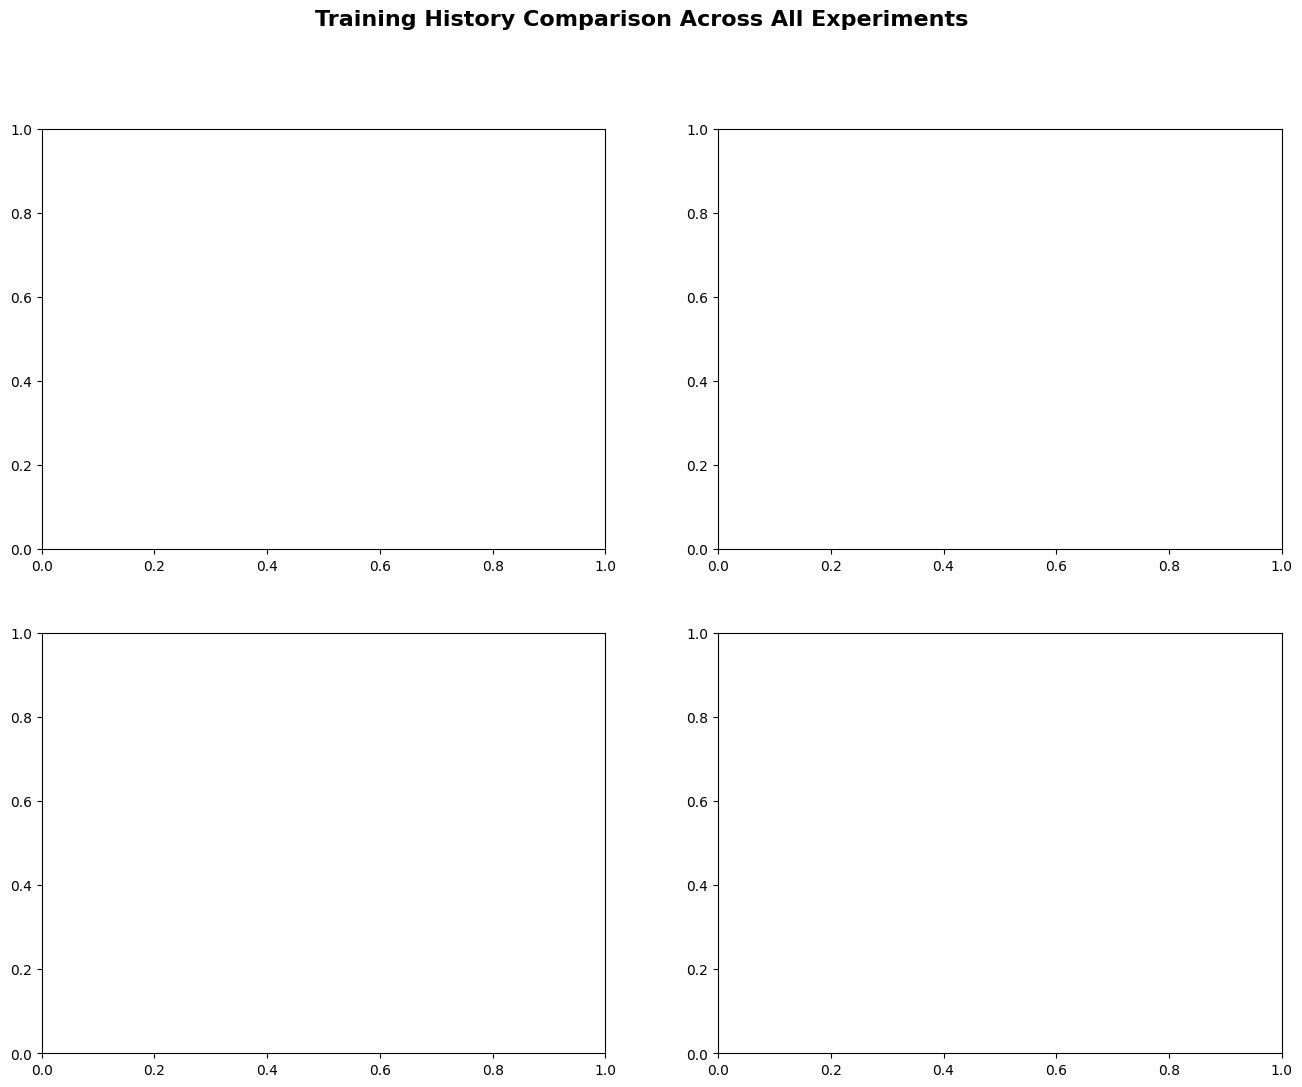

In [11]:
# Create detailed comparison plots for all experiments
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training History Comparison Across All Experiments',
             fontsize=16, fontweight='bold')

# Define colors for each label fraction
colors = {0.3: 'blue', 0.5: 'green', 0.7: 'red'}

# Plot 1: Training Loss
for r in all_results:
    label_frac = r['label_fraction']
    history = r['history']
    epochs = range(1, len(history['train_loss']) + 1)
    axes[0, 0].plot(epochs, history['train_loss'],
                    label=f"{int(label_frac*100)}%",
                    color=colors[label_frac], linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Training Loss', fontsize=13, fontweight='bold')
axes[0, 0].legend(title='Label Fraction', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Loss
for r in all_results:
    label_frac = r['label_fraction']
    history = r['history']
    epochs = range(1, len(history['val_loss']) + 1)
    axes[0, 1].plot(epochs, history['val_loss'],
                    label=f"{int(label_frac*100)}%",
                    color=colors[label_frac], linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].set_title('Validation Loss', fontsize=13, fontweight='bold')
axes[0, 1].legend(title='Label Fraction', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Validation mIoU
for r in all_results:
    label_frac = r['label_fraction']
    history = r['history']
    epochs = range(1, len(history['val_miou']) + 1)
    axes[1, 0].plot(epochs, history['val_miou'],
                    label=f"{int(label_frac*100)}%",
                    color=colors[label_frac], linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('mIoU', fontsize=11)
axes[1, 0].set_title('Validation mIoU', fontsize=13, fontweight='bold')
axes[1, 0].legend(title='Label Fraction', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Validation Accuracy
for r in all_results:
    label_frac = r['label_fraction']
    history = r['history']
    epochs = range(1, len(history['val_acc']) + 1)
    axes[1, 1].plot(epochs, history['val_acc'],
                    label=f"{int(label_frac*100)}%",
                    color=colors[label_frac], linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].set_title('Validation Pixel Accuracy',
                     fontsize=13, fontweight='bold')
axes[1, 1].legend(title='Label Fraction', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'training_curves_all.png',
            dpi=150, bbox_inches='tight')
plt.show()

print(f"Training curves saved to: {RESULTS_DIR / 'training_curves_all.png'}")

## Visualization


In [ ]:
best_exp = max(all_results, key=lambda x: x['best_val_miou'])
best_model_path = Path(best_exp['exp_dir']) / 'best_model.pth'

vis_model = get_unet(
    model_type=best_exp['architecture'],
    classes=CONFIG['num_classes'],
    in_channels=3
)
checkpoint = torch.load(
    best_model_path, map_location=device, weights_only=False)
vis_model.load_state_dict(checkpoint['model_state_dict'])
vis_model = vis_model.to(device)
vis_model.eval()

vis_dataset = LandCoverDataset(
    data_dir=DATA_ROOT,
    split='val',
    transform=get_val_transform(resize_to=CONFIG['resize_to']),
    labeled_fraction=1.0,
    use_split_file=True
)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle(
    f'Best Model: {best_exp["architecture"].upper()} ({int(best_exp["label_fraction"]*100)}% labels)', fontsize=14)

for i in range(3):
    image, mask_gt = vis_dataset[i]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = vis_model(image_input)
        pred = output.argmax(dim=1).squeeze(0).cpu()

    img_np = image.cpu().permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = np.clip(std * img_np + mean, 0, 1)

    masked_gt = mask_labels_random(
        mask_gt.numpy(), best_exp['label_fraction'], seed=42)

    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask_to_rgb(mask_gt.numpy()))
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(mask_to_rgb(masked_gt))
    axes[i, 2].set_title(
        f'Partial Labels ({int(best_exp["label_fraction"]*100)}%)')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(mask_to_rgb(pred.numpy()))
    axes[i, 3].set_title('Prediction')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'predictions.png', dpi=150)
plt.show()